### Depth_change_histograms

#### ...for testing the histogram

Read the interpolated DEMs and make histograms of 
This reads the .nc files created by `CoreBx_multi`. Those files need to be updated

TODO:
* If the x, y labeling changes in CoreBx_multi, then correct here too.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
# from dask.distributed import LocalCluster
from scipy import interpolate, signal
%matplotlib inline

In [2]:
# define all of the functions by runnng this python file
%run -i CoreBx_funcs

In [3]:
# default blue
dblue = '#1f77b4'

In [4]:
# This block is copied from CoreBx_multi, with addition of xs_end and d_end

# Make an array of dicts, where analysis region is defined by:
#  name
#  e0 - UTM Easting of origin [m]
#  n0 - UTM Northing of origin [m]
#  xlen - Length of alongshore axis [m]
#  ylen - Length of cross-shore axis [m]
#  dxdy - grid size (must be isotropic right now) [m]
#  theta - rotation CCW from x-axis [deg]
#  xs_end - number of grid cells to approximate limit of overwash terrace
#  d_end - number of grid cells to 

# regions = [
#            {'name':"region_4","e0": 387330.,"n0": 3864280.,"xlen": 4000.,"ylen": 700.,"dxdy": 1.,"theta": 45.,'xs_end':400,'d_end':200}]

# Region 1 has been modified to keep it in the domain of the DEMs, in keeping with CoreBx_multi_v2.
regions = [{'name':"region_1","e0": 380500.,"n0": 3858240.,"xlen": 3400.,"ylen": 600.,"dxdy": 1.,"theta": 42.,'xs_end':400,'d_end':300},
           {'name':"region_2","e0": 383440.,"n0": 3860830.,"xlen": 3990.,"ylen": 700.,"dxdy": 1.,"theta": 41.,'xs_end':300,'d_end':200},
           {'name':"region_3","e0": 386485.,"n0": 3863430.,"xlen": 1200.,"ylen": 700.,"dxdy": 1.,"theta": 44.,'xs_end':350,'d_end':200},
           {'name':"region_4","e0": 387330.,"n0": 3864280.,"xlen": 4000.,"ylen": 700.,"dxdy": 1.,"theta": 45.,'xs_end':400,'d_end':200},
           {'name':"region_5","e0": 390140.,"n0": 3867115.,"xlen": 3400.,"ylen": 700.,"dxdy": 1.,"theta": 43.75,'xs_end':350,'d_end':200},
           {'name':"region_6","e0": 392600.,"n0": 3869450.,"xlen": 2440.,"ylen": 700.,"dxdy": 1.,"theta": 42.,'xs_end':400,'d_end':200},
           {'name':"region_7","e0": 394430.,"n0": 3871065.,"xlen": 3220.,"ylen": 700.,"dxdy": 1.,"theta": 42.,'xs_end':400,'d_end':200},
           {'name':"region_8","e0": 396800.,"n0": 3873240.,"xlen": 3500.,"ylen": 700.,"dxdy": 1.,"theta": 42.,'xs_end':400,'d_end':250},
           {'name':"region_9","e0": 399400.,"n0": 3875580.,"xlen": 3300.,"ylen": 700.,"dxdy": 1.,"theta": 40.,'xs_end':450,'d_end':250}]

CoreBx_funcs.py:42: RuntimeWarning: invalid value encountered in less_equal
  mad = np.nanmean(np.abs(mp),axis=(1,2))
CoreBx_funcs.py:76: RuntimeWarning: invalid value encountered in true_divide
  print("mad",mad,file=sfile)


treat cabins


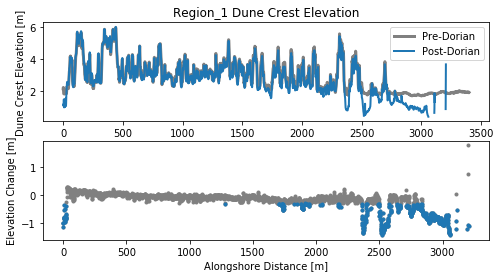

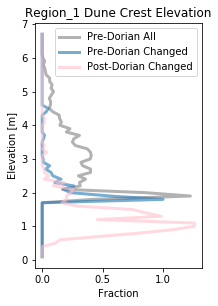

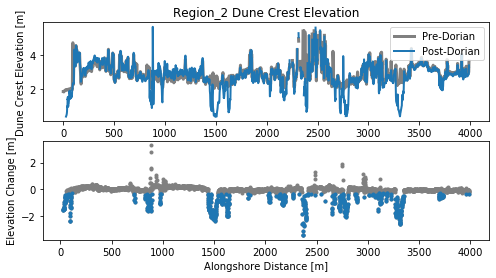

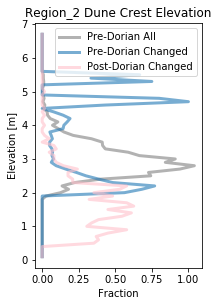

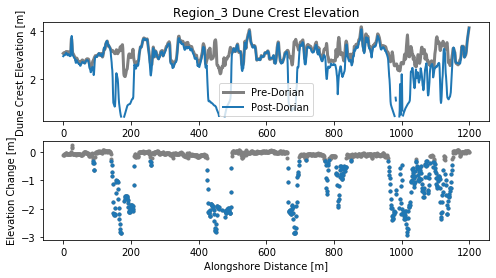

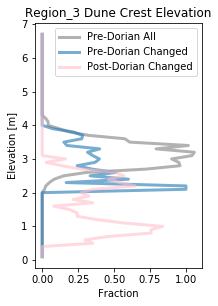

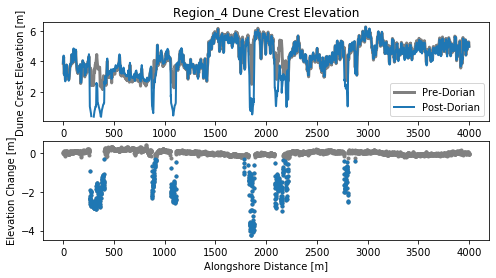

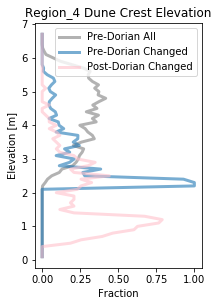

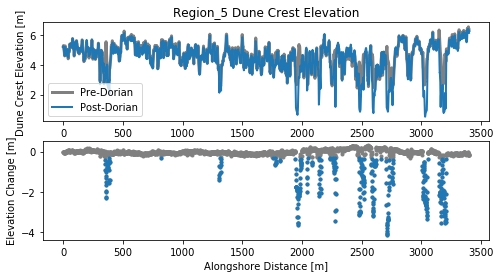

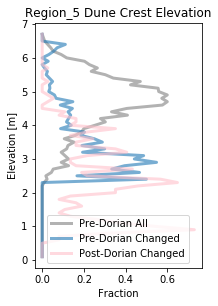

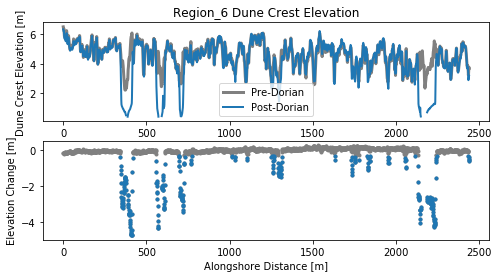

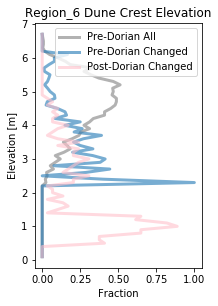

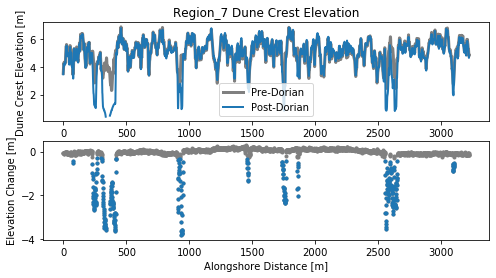

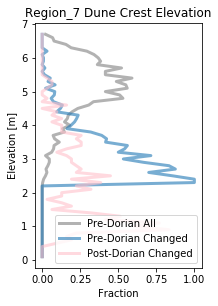

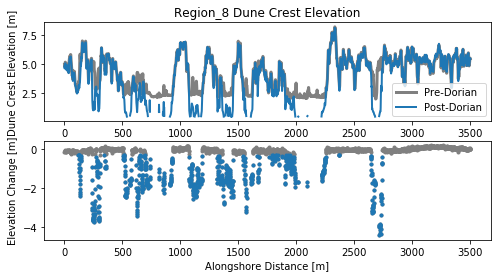

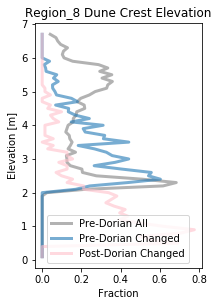

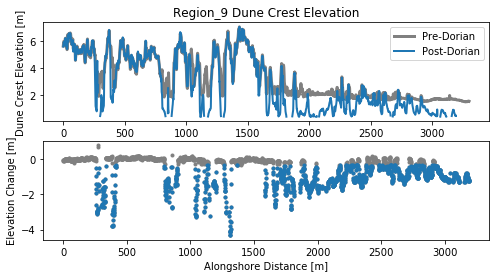

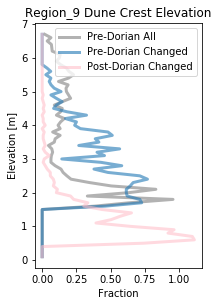

In [11]:
# Initialize arrays for histogram results
bin_edges = np.arange(0,6.75,.1)
h0all = np.zeros_like(bin_edges[0:-1])
h0sall = np.zeros_like(bin_edges[0:-1])
h1all = np.zeros_like(bin_edges[0:-1])
h2all = np.zeros_like(bin_edges[0:-1])
pctall = np.zeros_like(bin_edges[0:-1])

for r in regions:
#     print()
#     print(r['name'])
    fn = r['name']+'.nc'
    dsa = xr.open_dataset(fn)
    dsaa = np.squeeze(dsa.to_array())
    # print(dsaa)

    # The first SfM map is about 17 cm high...correct that.
    dsaa[0,:,:] = dsaa[0,:,:] - 0.17 

    dsaa = dsaa.where(dsaa>=0.4)
    diffmap = np.squeeze(np.diff(dsaa,axis=0))

    title_str = '{0:s}'.format(r['name'].capitalize())

    # calculate dhi
    dhi = dsaa[:,0:r['d_end'],:].max(axis=1,skipna=True).values

    x = np.arange(0,np.shape(dhi)[1])
#     print("Shape x: ",np.shape(x))
    
    if r['name']=="region_2":
        print("treat cabins")
        dhi[:,np.where(dhi[0,:]>5.5)]=np.nan
        
#     print("Shape dhi: ",np.shape(dhi))
    mean_dhi = np.nanmean(dhi,1)
    std_dhi = np.nanstd(dhi,1)
    

    
    hdiff = np.squeeze(np.diff(dhi,1,0))   
    idx = np.where(hdiff<=-.3)
    
    # Plot to evaluate difference threshold
    fig = plt.figure(figsize=(8,4))
    ax1=plt.subplot(211)
    title_str = '{0:s} Dune Crest Elevation'.format(r['name'].capitalize())
    plt.plot(x,dhi[0,:],color='gray',linewidth=3,label="Pre-Dorian")
    plt.plot(x,dhi[1,:],color=dblue,linewidth=2,label="Post-Dorian")
    plt.legend()
    plt.ylabel('Dune Crest Elevation [m]')
    plt.title(title_str)
    ax2=plt.subplot(212)
    plt.plot(x, hdiff,'.',c='gray')
    plt.plot(x[idx], hdiff[idx],'.',c=dblue)
    plt.ylabel('Elevation Change [m]')
    plt.xlabel('Alongshore Distance [m]')

#     fig_name = r['name']+'dune_crest.png'
#     plt.savefig(fig_name, dpi = 300)
    
    # Histogram of all dhi
    h0, be = np.histogram(dhi[0,:],np.arange(0,6.8,.1),density=False)
    h0s, be = np.histogram(dhi[0,:],np.arange(0,6.8,.1),density=True)

    # Histogram of pre-storm dhi that change during storm
    h1, be = np.histogram(dhi[0,idx],np.arange(0,6.8,.1),density=False)

    # Histogram of post-storm dhs that change during storm
    h2, be = np.histogram(dhi[1,idx],np.arange(0,6.8,.1),density=False)

    # Same as above above, but scaled to 0-1
    h2s,be = np.histogram(dhi[1,idx],np.arange(0,6.8,.1),density=True)

    # Fraction of dhi in each elevation range that changed
    pct = h1/h0
    pct = np.nan_to_num(pct,copy=False,nan=0.0)
#     print(pct)
    
    try:
        h0sall=h0sall+h0s
        h0all=h0all+h0
        h1all=h1all+h1
        h2all=h2all+h2
        pctall = pctall + pct
    except:
        print('should not see this')
    
    bin_centers = bin_edges[0:-1]+np.diff(bin_edges)
    
    # Histogram
    fig = plt.figure(figsize=(3,4.5))
    ax = plt.subplot(111)
    plt.plot( h0s, bin_centers,linewidth=3, c="gray", alpha=.6, label="Pre-Dorian All")
    plt.plot( pct, bin_centers,linewidth=3, c=dblue, alpha=.6, label="Pre-Dorian Changed")
    plt.plot( h2s, bin_centers,linewidth=3, c="pink", alpha=.6, label="Post-Dorian Changed")
    plt.legend()
    ax.set_ylabel("Elevation [m]")
    ax.set_xlabel("Fraction")
    plt.title(title_str)

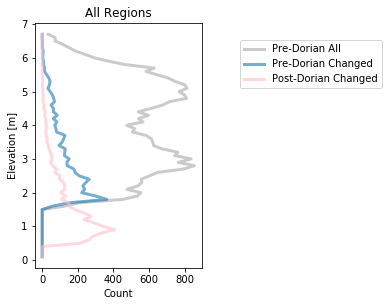

In [6]:
# These commands choose fonts that are editable in svg format
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42   

# Histogram of all

fig = plt.figure(figsize=(3,4.5))
ax = plt.subplot(111)
plt.plot( h0all, bin_centers,linewidth=3,alpha=.6, c="darkgray",label="Pre-Dorian All")

plt.plot( h1all, bin_centers,linewidth=3,alpha=.6, c=dblue, label="Pre-Dorian Changed")
plt.plot( h2all, bin_centers,linewidth=3,alpha=.6, c="pink",label="Post-Dorian Changed")
plt.legend(bbox_to_anchor=(1.2, 0.95))
ax.set_ylabel("Elevation [m]")
ax.set_xlabel("Count")
plt.title("All Regions")
fig.savefig("histogram.svg", bbox_inches='tight', format='svg')

pctall:  1.0
h2sall:  1.0


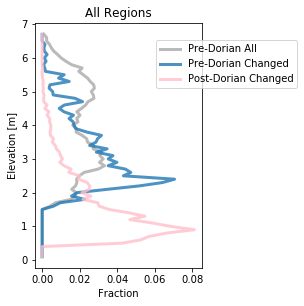

In [13]:
    pctall = pctall/np.nansum(pctall)
    h2sall = h2all/np.sum(h2all)
    h0sall = h0sall/np.nansum(h0sall)
    
    fig = plt.figure(figsize=(3,4.5))
    ax = plt.subplot(111)
    plt.plot( h0sall, bin_centers,linewidth=3,alpha=.8, c="darkgray",label="Pre-Dorian All")

    plt.plot( pctall, bin_centers,linewidth=3,alpha=.8, c=dblue, label="Pre-Dorian Changed")
    plt.plot( h2sall, bin_centers,linewidth=3,alpha=.8, c="pink",label="Post-Dorian Changed")
    plt.legend(bbox_to_anchor=(1.6, 0.95))
    ax.set_ylabel("Elevation [m]")
    ax.set_xlabel("Fraction")
    plt.title("All Regions")

    print("pctall: ",np.nansum(pctall))
    print("h2sall: ",np.nansum(h2sall))
